# Flight Delay Bayesian Network Analysis

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pomegranate import *
%matplotlib inline

In [3]:
#Read flight data for the year 2015
data = pd.read_csv(r'data/flights.csv')

/Users/pear/anaconda/envs/env_gdal/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
data.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data.shape

(5819079, 31)

In [10]:
data.columns

Index([u'YEAR', u'MONTH', u'DAY', u'DAY_OF_WEEK', u'AIRLINE', u'FLIGHT_NUMBER',
       u'TAIL_NUMBER', u'ORIGIN_AIRPORT', u'DESTINATION_AIRPORT',
       u'SCHEDULED_DEPARTURE', u'DEPARTURE_TIME', u'DEPARTURE_DELAY',
       u'TAXI_OUT', u'WHEELS_OFF', u'SCHEDULED_TIME', u'ELAPSED_TIME',
       u'AIR_TIME', u'DISTANCE', u'WHEELS_ON', u'TAXI_IN',
       u'SCHEDULED_ARRIVAL', u'ARRIVAL_TIME', u'ARRIVAL_DELAY', u'DIVERTED',
       u'CANCELLED', u'CANCELLATION_REASON', u'AIR_SYSTEM_DELAY',
       u'SECURITY_DELAY', u'AIRLINE_DELAY', u'LATE_AIRCRAFT_DELAY',
       u'WEATHER_DELAY'],
      dtype='object')

In [10]:
#looking at missing values
data.count()

YEAR                   5819079
MONTH                  5819079
DAY                    5819079
DAY_OF_WEEK            5819079
AIRLINE                5819079
FLIGHT_NUMBER          5819079
TAIL_NUMBER            5804358
ORIGIN_AIRPORT         5819079
DESTINATION_AIRPORT    5819079
SCHEDULED_DEPARTURE    5819079
DEPARTURE_TIME         5732926
DEPARTURE_DELAY        5732926
TAXI_OUT               5730032
WHEELS_OFF             5730032
SCHEDULED_TIME         5819073
ELAPSED_TIME           5714008
AIR_TIME               5714008
DISTANCE               5819079
WHEELS_ON              5726566
TAXI_IN                5726566
SCHEDULED_ARRIVAL      5819079
ARRIVAL_TIME           5726566
ARRIVAL_DELAY          5714008
DIVERTED               5819079
CANCELLED              5819079
CANCELLATION_REASON      89884
AIR_SYSTEM_DELAY       1063439
SECURITY_DELAY         1063439
AIRLINE_DELAY          1063439
LATE_AIRCRAFT_DELAY    1063439
WEATHER_DELAY          1063439
dtype: int64

How many cancelled flights?

In [15]:
data['CANCELLED'].value_counts()

0    5729195
1      89884
Name: CANCELLED, dtype: int64

In [19]:
count = data['CANCELLED'].value_counts()
print 'Non cancelled flight:',count[0]-count[1]
print 'Percent of flights cancelled:', float(count[1])*100./len(data)

Non cancelled flight: 5639311
Percent of flights cancelled: 1.54464306121


Examining departure_delay, which gives departure_time-scheduled_time.

In [20]:
#Are the missing values in departure_delay because of cancellation?
data.loc[data['DEPARTURE_DELAY'].isnull(),'CANCELLED'].value_counts()

1    86153
Name: CANCELLED, dtype: int64

Yes, all the missing entries for departure_delay are cancelled flights. Makes sense. However, there are some cancelled flights that have departure_delay values. Not sure why. Let's see the distribution.

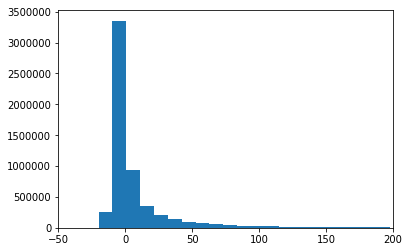

In [28]:
fig, ax = plt.subplots()
ax.set_xlim([-50,200])
ax.hist(data.loc[data['DEPARTURE_DELAY'].notnull(),'DEPARTURE_DELAY'],bins=200)
plt.show()

The negative values are the flights that departed early. We are going to classify flights with delay time >= 15 mins as delayed. How many delayed flights?

In [35]:
delayed_count = (data['DEPARTURE_DELAY']>=15.).value_counts()

In [36]:
delayed_count

False    4761525
True     1057554
Name: DEPARTURE_DELAY, dtype: int64

In [38]:
print 'Percentage of delayed flights:', delayed_count[1]*100./len(data)

Percentage of delayed flights: 18.1739069018


Since we are concerned with flights that did not leave as scheduled, we want to include cancelled flights in the prediction as well. We are going to add a column for delayed/cancelled flights.

In [39]:
data['delayed'] = (data['DEPARTURE_DELAY']>=15.)|(data['CANCELLED']==1)

In [45]:
print 'Percentage of delayed/cancelled:',(data['delayed']==True).sum()*100./len(data)

Percentage of delayed/cancelled: 19.683252281


## Testing a simple Bayes Net

In [49]:
prob_airlines = DiscreteDistribution.from_samples(data['AIRLINE'].values)

In [50]:
prob_airlines

{
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        {
            "AA" :0.12475926173196823,
            "OO" :0.10110758077008407,
            "DL" :0.15051883640005576,
            "NK" :0.020171405131293115,
            "EV" :0.09829338972713723,
            "F9" :0.01561003038453336,
            "B6" :0.0458917983412839,
            "US" :0.0341488747617965,
            "AS" :0.029647475141684792,
            "MQ" :0.05063206737698526,
            "WN" :0.21684788950278902,
            "VX" :0.01063793772175975,
            "HA" :0.013107228824355194,
            "UA" :0.08862622418427384
        }
    ],
    "name" :"DiscreteDistribution"
}

In [51]:
prob_months = DiscreteDistribution.from_samples(data['MONTH'].values)

In [52]:
prob_months

{
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        {
            "11" :0.08042028644051748,
            "10" :0.0835467262087351,
            "12" :0.08235495685829321,
            "1" :0.0807632960473642,
            "3" :0.0866652609459332,
            "2" :0.07375582974556627,
            "5" :0.08540750177132841,
            "4" :0.08337247182930495,
            "7" :0.08948460744389275,
            "6" :0.08659394381825715,
            "9" :0.07990027287823383,
            "8" :0.08773484601257346
        }
    ],
    "name" :"DiscreteDistribution"
}

In [56]:
prob_delayed = ConditionalProbabilityTable.from_samples(data[['AIRLINE','MONTH','delayed']].values,
                                                        [prob_airlines,prob_months])

In [58]:
s1 = State(prob_airlines, name='airline')
s2 = State(prob_months, name='month')
s3 = State(prob_delayed, name='delayed')

In [59]:
model = BayesianNetwork('flight_delay')

In [60]:
model.add_states(s1, s2, s3)

In [61]:
model.add_transition(s1, s3)
model.add_transition(s2, s3)
model.bake()

In [68]:
model.predict_proba({'airline':'UA'})

array([ {
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        {
            "AA" :0.0,
            "OO" :0.0,
            "DL" :0.0,
            "NK" :0.0,
            "EV" :0.0,
            "F9" :0.0,
            "B6" :0.0,
            "US" :0.0,
            "AS" :0.0,
            "MQ" :0.0,
            "WN" :0.0,
            "VX" :0.0,
            "HA" :0.0,
            "UA" :1.0
        }
    ],
    "name" :"DiscreteDistribution"
},
       {
    "frozen" :false,
    "class" :"Distribution",
    "parameters" :[
        {
            "11" :0.0804202864405175,
            "10" :0.08354672620873516,
            "12" :0.08235495685829321,
            "1" :0.08076329604736412,
            "3" :0.08666526094593324,
            "2" :0.07375582974556634,
            "5" :0.0854075017713284,
            "4" :0.083372471829305,
            "7" :0.0894846074438927,
            "6" :0.08659394381825715,
            "9" :0.07990027287823387,
            "8" :0.0877348460